In [1]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv

from scipy import *
from scipy.linalg import norm, pinv
 

from sympy import symbols, diff
import matplotlib.pyplot as plt



In [31]:
def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,2))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err

In [42]:
np.random.seed(0)

def radialbasisfunc(beta, c, d):
    return exp(-beta * norm(c-d)**2)
     
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    G = zeros((X.shape[0], numNeurons), float)
    for ci, c in enumerate(centers):
        for xi, x in enumerate(X):
            G[xi,ci] = radialbasisfunc(beta, c, x)
    return G
     
def trainrbf(X, Y, beta, numNeurons):
    """ X: matrix of dimensions n x indim 
        y: column vector of dimension n x 1 """
         
    # choose random center vectors from training set
    
    #We permute randomly the centers indices
    rnd_idx = random.permutation(X.shape[0])[:numNeurons]
    
    #Centers contain all points X(1:rnd_idx) play the role of neurons
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    
    print "center", centers
    
    # calculate activations of RBFs
    G = activation(X, beta, numNeurons, centers)
    G = np.append(G, X, axis =1)
    G = np.append(G, np.ones((n,1), "float"), axis = 1)
        
    # calculate output weights (pseudoinverse)
    W = dot(pinv(G), Y)
    
    print W.shape[0]
    
    Q = (dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(G), Y)))
    
    L = [W, Q, centers]
    
    print W
    print Q
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    G = activation(X, beta, numNeurons, centers)
    G = np.append(G, X, axis=1)
    G = np.append(G, np.ones((n,1), "float"), axis=1)
    Y = dot(G, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    return Y



center [[ 2.39439439  2.39439439]
 [ 4.06006006  4.06006006]
 [ 6.67867868  6.67867868]
 [-2.77877878 -2.77877878]
 [ 5.78978979  5.78978979]
 [-0.64864865 -0.64864865]
 [-3.51551552 -3.51551552]
 [-1.36136136 -1.36136136]
 [-2.06606607 -2.06606607]
 [ 3.21921922  3.21921922]
 [ 0.08008008  0.08008008]
 [ 4.91691692  4.91691692]
 [-7.56756757 -7.56756757]
 [ 7.56756757  7.56756757]
 [-5.86986987 -5.86986987]
 [ 0.82482482  0.82482482]
 [-6.7027027  -6.7027027 ]
 [-4.27627628 -4.27627628]
 [-5.06106106 -5.06106106]
 [ 1.59359359  1.59359359]]
22
[[ -0.32429428]
 [ -0.83290162]
 [ -0.30652773]
 [ -0.55349284]
 [ -0.61725069]
 [-10.7273803 ]
 [ -0.75845894]
 [ -7.1018969 ]
 [ -1.93253754]
 [ -0.52512255]
 [  0.96738233]
 [ -0.77369502]
 [ -1.20240099]
 [ -0.47917802]
 [ -1.00263662]
 [  9.79879593]
 [ -1.23452343]
 [ -1.01620436]
 [ -0.82080941]
 [  4.06822897]
 [ -0.04978341]
 [  0.83661092]]
[[ 978.74599367]]


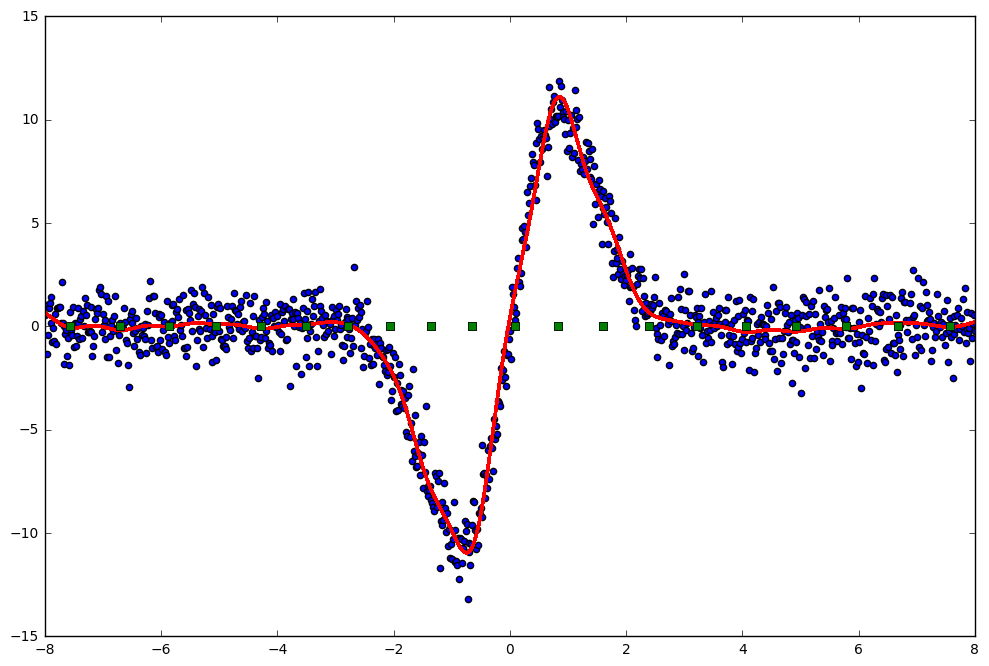

In [55]:
n = 1000

#Specify Dimension of inputs and outputs
InputDimension = 1
OutputDimension = 1
     
#Define the bound of the focused interval    
lbound = -8
ubound = 8
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)
# set y and add random noise
    
    
#Function 1
y = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
#y = 0.9*x-50*np.exp(-x**2/2)+1

y += random.normal(0, 1, y.shape)

     
#Initialize parameters of the radial basis function
    
#Number of Gaussian centers
numNeurons = 20

#Define the size of the kernels 
beta = 2


######### Start RBF regression #############

#Train the neural network on the data x
parameters = trainrbf(x, y , beta, numNeurons)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])
       
# plot original data
plt.figure(figsize=(12, 8))

for i in range(n):
    plt.scatter(x[i], y[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs')
     
plt.xlim(lbound, ubound)
plt.show()

plt.savefig("graphs/RBF_1.eps",format = "eps")